# Run Random Game

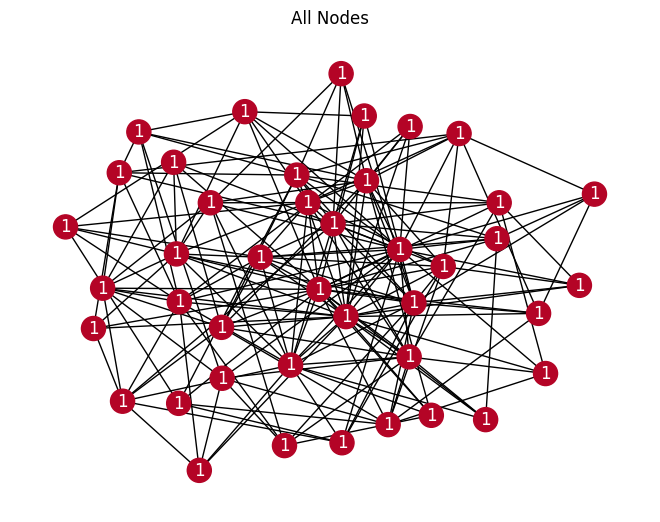

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [1]:
from utils.environment.CIgame import GraphGame
from utils.environment.envhelper import gen_new_graphs

import numpy as np
import pyspiel
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

def drawNetwork(graph,name):
    d = nx.get_node_attributes(graph, "active") 
    low, *_, high = sorted(d.values())
    norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm_r)
    nx.draw_kamada_kawai(graph, 
            nodelist=d,
            labels=d,
            node_color=[mapper.to_rgba(i) 
                        for i in d.values()], 
            with_labels=True,
            font_color='white',
            connectionstyle='arc3, rad = 0.1',
            arrowsize = 10,
            arrows=False)
    plt.title("All Nodes")
    plt.show()
    #plt.savefig("./0/"+name)
    plt.clf()

def get_degree(subgraph):
    degree_node = np.array(subgraph.degree())
    sorted = degree_node[np.argsort(degree_node[:, 1])]
    sorted = sorted[::-1]
    return sorted
#pyspiel.register_game(_GAME_TYPE, GraphGame)
game = pyspiel.load_game("graph_attack_defend")
state = game.new_initial_state(gen_new_graphs(['barabasi_albert'],seed=0))
i = 0
drawNetwork(state.Graph.to_networkx(),"Test")
while not state.is_terminal():
    legal_actions = state.legal_actions()
    acc = state.Graph.subgraph(legal_actions)
    sorted_nodes = get_degree(acc.to_networkx())
    act = sorted_nodes[:,0]
    #action = act[0:2]
    action = act[0] #np.random.choice(legal_actions,2)
    state.apply_actions([action,action])
    i+=1
#print(state.Graph.G.nodes(data="active"))
drawNetwork(state.Graph.to_networkx(),"Test")
plt.plot(state.lcc,color='red')
plt.show()
plt.plot(np.cumsum(state.r),color='green')
plt.title("LCC/n vs iteration")
#plt.savefig("LCC_Plot_Random")
plt.show()
print(state.Graph.es)


# Training 


In [ ]:
"""DQN agents trained on Breakthrough by independent Q-learning."""
from utils.environment.CIgame import GraphGame
from utils.reinforcement_learning.rl_environment import Environment
from utils.validation import get_Validation, area_under_curve
from utils.reinforcement_learning.dqn import DQN
from utils.reinforcement_learning.CIGraphNN import CIGraphNN
from utils.params import Params

from tqdm import tqdm
import torch
import copy
import numpy as np
from datetime import datetime
from open_spiel.python.algorithms import random_agent


# Training parameters
params = Params("./utils/CI_ba_params.json")

def Generate_Batch_Graph(size,seed = None):
    Batch_Graph = [gen_new_graphs(graph_type=['barabasi_albert'],seed=seed+i) for i in range(size)]
    return np.array(Batch_Graph,dtype=object)
evaluation, eval_x = get_Validation(params.validation_test_size)#get_Validation(4,file_path)

def main(agents=None):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]  
    size_CV = params.validation_test_size
    CV_AUC = []
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if agents == None:
        agents = [
            DQN(
                player_id=0,
                state_representation_size=params.centrality_features,
                global_feature_size = params.global_features,
                num_actions=num_actions,
                hidden_layers_sizes=params.hidden_layers,
                replay_buffer_capacity=int(params.replay_buffer_capacity),
                learning_rate=params.learning_rate,
                update_target_network_every=  params.update_target_network_every,
                learn_every=params.learn_every,
                discount_factor=params.discount_factor,
                min_buffer_size_to_learn=params.min_buffer_size_to_learn,
                power = params.epsilon_power,
                nsteps=params.nstep,
                epsilon_start=params.epsilon_start,
                epsilon_end=params.epsilon_end,
                epsilon_decay_duration=params.epsilon_decay_duration,
                batch_size=params.batch_size,
                GraphNN = CIGraphNN)
        ]
    #agents.append(random_agent.RandomAgent(player_id=1, num_actions=num_actions))
    graph_batch_size = params.graph_batch_size
    for ep in tqdm(range(int(params.num_train_episodes))):
        if (ep) % params.graph_suffle == 0:
            Batch_Graph = Generate_Batch_Graph(graph_batch_size,seed=ep)
        time_step = env.reset(Batch_Graph[int(ep%graph_batch_size)].copy())
        while not time_step.last():
            agents_output = [agent.step(time_step) for agent in agents]
            actions = [agent_output.action for agent_output in agents_output]
            action_list = [actions[0], actions[0]]
            time_step = env.step(action_list)
        for agent in agents:
            agent.step(time_step)
        if (ep + 1) % params.eval_every == 0:
            AUC = []
            for i in range(size_CV):
                eval_step = env.reset(evaluation[i].copy())
                while not eval_step.last():
                    eval_output = [agent.step(eval_step, is_evaluation=True) for agent in agents]
                    actions = [agent_output.action for agent_output in eval_output]
                    action_list = [actions[0], actions[0]]
                    eval_step = env.step(action_list)
                lcc = env.get_state.lcc
                AUC.append(area_under_curve(eval_x[i][:len(lcc)],lcc))
            meanAUC = np.mean(AUC)
            CV_AUC.append(meanAUC)

        if (ep + 1) % params.save_every == 0:
            checkpoint = {'_q_network': agents[0]._q_network.state_dict(),'target_q_network': agents[0]._target_q_network.state_dict(),'_optimizer' :agents[0]._optimizer.state_dict()}
            title = params.checkpoint_dir+"_"+str(ep+1)
            torch.save(checkpoint, title)
    return agents,CV_AUC
agents =None#[torch.load('./model/DiffSize_BA_Graph/model_BAGraph_100000')]
agents,CV_AUC= main(agents)    

  0%|          | 33/500000 [00:04<16:53:19,  8.22it/s]


ValueError: operands could not be broadcast together with shapes (27,) (34,) 

In [ ]:
CV_AUC = np.array(CV_AUC)
save_every= 500            
num_train_episodes = int(5e5) 
x = np.arange(500,num_train_episodes+save_every,save_every)
min_value = np.argmin(CV_AUC)
min_vc = x[min_value]
plt.plot(x,CV_AUC,color='red')
plt.plot(min_vc, CV_AUC[min_value], marker="o", markersize=5, markeredgecolor='orange', markerfacecolor="None",label="Min: "+str(min_vc))
plt.title("AUC of LCC vs Nodes Plot BA")
plt.xlabel("iteration")
plt.ylabel("AUC")
plt.legend()
plt.show()


# END